## Test the jaxpower codes

In [17]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import random
import logging
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,join,Column
import lsstypes as types

import jax
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging

sys.path.append('../../')
from helper import REDSHIFT_BIN_OVERALL, REDSHIFT_BIN_LSS, REDSHIFT_ABACUSHF_v1, NRAN, TRACER_CUTSKY_INFO
from helper import GET_REPEATS_DV, GET_CTHR, GET_REPEATS_NUMBER, SELECT_REGION
from cat_tools import read_positions_weights
%load_ext autoreload
%autoreload 2
%matplotlib inline

BASE_DIR = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'

def zfmt(x):
    return f"{x:.3f}".replace(".", "p")

BOXSIZE = 2000
NSPLITS = 10
ells = (0, 2, 4)
kedges   = np.arange(0.,0.4001,0.001) # for PK
# kmin, kmax, kbin, lenk = 0.02, 0.2, 0.005, 36

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
tracer = 'LRG'
indz = 0
znap = REDSHIFT_ABACUSHF_v1[tracer][indz]
zrange = REDSHIFT_BIN_LSS[tracer][indz]
data_args = {'version':'AbacusHF-v1', 'domain':'cutsky', 'tracer':tracer, 'zsnap': znap, 'zrange':zrange, 'mock_id': 0}
# data_positions, _ = read_positions_weights(**data_args, use_zrr=False)

get_data = lambda: read_positions_weights(**data_args, use_zerr=None)
get_random = lambda: read_positions_weights(**data_args, use_random=True, nran=1)

In [3]:
data = get_data()
random = get_random()

data_positions, data_weights = data
random_positions, _randoms_weights = random

In [19]:
data_positions = data_positions[:,:5000]
random_positions = random_positions[:,:20000]

In [15]:
randoms = tuple(x.T for x in get_random())

In [14]:
randoms = random


In [23]:
def load_mesh2_spectrum_poles(filename):
    result = types.read(filename)
    k = result.get(ells=0).coords('k')
    Pk = {ell: result.get(ells=ell).values() for ell in result.ells}
    return k, Pk

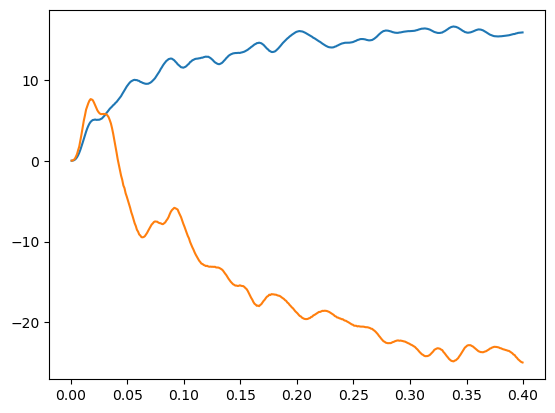

In [25]:
fn = './tests/LRG_mesh2_spectrum_poles.h5'
result = types.read(fn)
k, Pk = load_mesh2_spectrum_poles(fn)

for ell in [0,2]:
    plt.plot(k,k*Pk[ell]['value'])

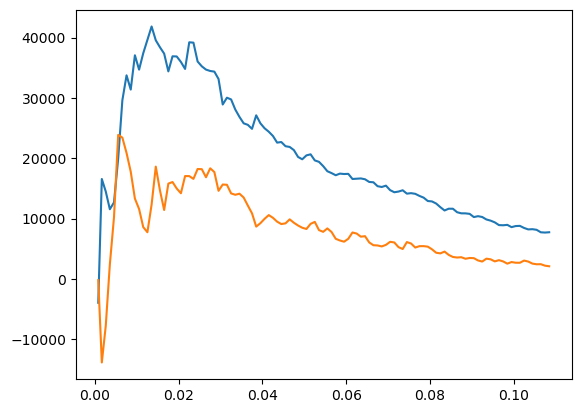

In [6]:
fn = './tests/pk_test_cutsky.npy'
result = PowerSpectrumMultipoles.load(fn)
pk = np.real(result.get_power())
k = result.kavg
plt.plot(k, pk[0])
plt.plot(k, pk[1])

In [ ]:
result.get


## Appendix

In [13]:
from jaxpower import (ParticleField, FKPField, compute_fkp2_normalization, compute_fkp2_shotnoise, BinMesh2SpectrumPoles, get_mesh_attrs, compute_mesh2_spectrum)

def get_proposed_mattrs(tracer):
    if 'BGS' in tracer:
        mattrs = dict(boxsize=4000., cellsize=7)
    elif 'LRG+ELG' in tracer:
        mattrs = dict(boxsize=9000., cellsize=10)
    elif 'LRG' in tracer:
        mattrs = dict(boxsize=7000., cellsize=7)
    elif 'ELG' in tracer:
        mattrs = dict(boxsize=9000., cellsize=10)
    elif 'QSO' in tracer:
        mattrs = dict(boxsize=10000., cellsize=10)
    else:
        raise NotImplementedError(f'tracer {tracer} is unknown')
    # mattrs.update(cellsize=10)
    return mattrs

In [ ]:
attrs = get_proposed_mattrs(tracer)
mattrs = get_mesh_attrs(data_positions, random_positions, check=True, **attrs)
data1 = ParticleField(data_positions, attrs=mattrs, exchange=True, backend='jax')
randoms1 = ParticleField(random_positions, attrs=mattrs, exchange=True, backend='jax')
fkp = FKPField(data1, randoms1)
# Paint FKP field to mesh
mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
# bin = BinMesh2SpectrumPoles(mattrs, edges={'step': 0.001}, ells=ells)
# norm = compute_fkp2_normalization(fkp, bin=bin, cellsize=10)
# num_shotnoise = compute_fkp2_shotnoise(fkp, bin=bin)

# wsum_data1 = data1.sum()
# jitted_compute_mesh2_spectrum = jax.jit(compute_mesh2_spectrum, static_argnames=['los'], donate_argnums=[0])
# spectrum = jitted_compute_mesh2_spectrum(mesh, bin=bin, los='firstpoint').clone(norm=norm, num_shotnoise=num_shotnoise)
# jax.block_until_ready(spectrum)

# los = 'firstpoint'
# output_fn = './tests/mesh_spectrum_poles_test.h5'
# mattrs = {name: mattrs[name] for name in ['boxsize', 'boxcenter', 'meshsize']}
# spectrum = spectrum.clone(attrs=dict(los=los, wsum_data1=wsum_data1, **mattrs))
# if output_fn is not None and jax.process_index() == 0:
#     # logger.info(f'Writing to {output_fn}')
#     spectrum.write(output_fn)

/global/homes/s/shengyu/.conda/envs/2pt_env/lib/python3.10/site-packages/jaxpower/mesh.py:1538: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rdtype = jnp.zeros((), dtype=dtype).real.dtype
/global/homes/s/shengyu/.conda/envs/2pt_env/lib/python3.10/site-packages/jaxpower/mesh.py:753: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  dtype = jnp.zeros((), dtype=dtype).dtype  # default dtype is float32, except if config.update('jax_enable_x64', True)
2025-12-22 05:57:20.947145: W extern

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4012012004 bytes.

FKPField(data=ParticleField(), randoms=ParticleField())